## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [1]:
#!pip install q category_encoders

In [2]:
#!pip install q lightgbm

In [3]:
#!pip install q hyperopt

In [5]:
%matplotlib inline

In [6]:
# для обработки ошибок 
import warnings

# для математических вычислений
import numpy as np

# для работы с таблицами
import pandas as pd

# для EDA анализа
import ydata_profiling

# для визуализации
import matplotlib.pyplot as plt

# для разбивки данных на выборки
from sklearn.model_selection import train_test_split

# для кодирования данных
import category_encoders as ce

# для масштабирования признаков
from sklearn.preprocessing import RobustScaler

# константная модель
from sklearn.dummy import DummyRegressor

# для расчёта качества моделей
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score

# модели машинного обучения
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# для реализации градиентного бустинга
import lightgbm as lgb

# для подбора гиперпараметров
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# для расчёта времени выполнения кода
import time

## 2 Открытие файла с данными и изучение общей информации
Считаем данные из csv-файла в датафрейм, сохраним в переменную `df` и проведём EDA анализ.

In [75]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv', index_col=[0], parse_dates=[0])
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv', index_col=[0], parse_dates=[0])
    ydata_profiling.ProfileReport(df, progress_bar=False).to_file(name + '.html')
    return df

In [77]:
df = read_eda('autos')

[Посмотреть анализ.](https://www.dropbox.com/s/onu005e1sar22u3/autos.html?dl=0)

- **В данных 354369 строк, 16 столбцов, 2 типа данных: int, object.**
- **Обнаружены некорректные названия столбцов.**
- **Присутствуют столбцы с идентификационными переменными.**
- **Присутствуют пропуски в нецелевых признаках.**
- **Нулевые минимальные значения в столбцах `Price`, `Power` и `RegistrationMonth` выглядят как аномалии.**
- **Максимальное значение столбца `Power` является аномалией, так как даже [самые мощные автомобили в мире](https://www.arenda-auto.ru/news/samye-moshchnye-avtomobili-v-mire.html) имеют меньшее кол-во лошадиных сил.**
- **Минимальное значение столбца `RegistrationYear` — аномалия, поскокльку машины появились позже ([история автомобиля](https://ru.wikipedia.org/wiki/%D0%98%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8F)), максимальное значение данного столбца также является аномалией, так как данный проект создаётся в 2023 году.**
- **Столбец `NumberOfPictures` полностью состоит из нулей, его позже удалим.**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>После изучения данных, стала ясна их общая структура:</b> 354369 строк, 16 столбцов, 2 типа данных: int, object.<br> <b>Также были обнаружены данные, подлежащие обработке:</b>
        <li>Названия столбцов.</li>
        <li>Столбцы с идентификационными переменными.</li>
        <li>Пропуски в нецелевых признаках.</li>
        <li>Дубликаты.</li>
        <li>Аномалии.</li>
    </p>  
</div>

## 3 Подготовка данных
### 3.1 Работа со столбцами
Добавим нижние подчёркивания между словами в названиях столбцов и изменим их регистр на нижний.

In [9]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]

Проверим названия.

In [10]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Удалим столбцы, содержащие идентификационные переменные, предварительно создав копию исходного датафрейма..

In [11]:
old_df = df.copy()
df = df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen'], axis=1)

Удалим столбец `number_of_pictures`, состоящий из нулей.

In [12]:
df = df.drop(['number_of_pictures'], axis=1)

### 3.2 Обработка пропусков
Определим процент пропусков по столбцам.

In [13]:
def find_nan():
    if max(list(df.isna().sum())) > 0:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(10, 3), legend=False, fontsize=14, grid=True)
            .set_title('Процент пропусков' + "\n", fontsize=16)    
        );    
    else:
        print('Пропусков нет.')

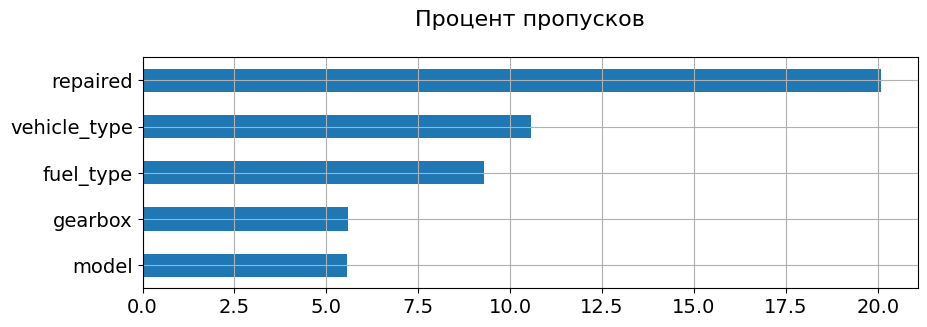

In [14]:
find_nan()

Посмотрим на уникальные значения данных столбцов.

In [15]:
for column in df.columns:
    if (df[column].dtype == object) and (column != 'brand'):
        print(column, '\n', df[column].unique(), '\n\n')

vehicle_type 
 [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 


gearbox 
 ['manual' 'auto' nan] 


model 
 ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'sp

**В столбцах `vehicle_type`, `model` и `fuel_type` присутствует значение `other`, им и заменим пропуски.**

In [16]:
df.fillna('other', inplace=True)

Проверим наличие пропусков.

In [17]:
find_nan()

Пропусков нет.


### 3.3 Устранение аномалий
**Столбцы `price` и `registration_month`**

Удалим сроки, содержащие нулевые значения.

In [18]:
df = df.loc[(df['price'] > 0) & (df['registration_month'] > 0)]

**Столбец `price`**

Построим увеличенную в масштабе диаграмму, чтобы посмотреть наличие около-нулевых значений.

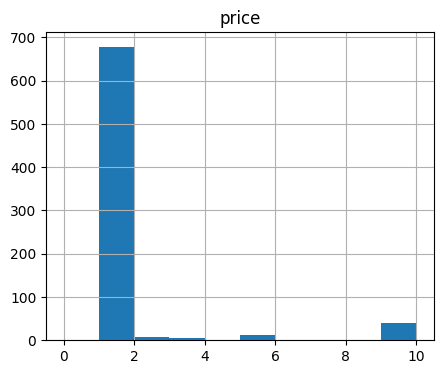

In [19]:
df.hist(column=['price'], range=(0, 10), figsize=(5, 4));

Удалим сроки, содержащие значения до 10.

In [20]:
df = df.loc[df['price'] > 10]

**Столбец `registration_year`**

Удалим строки, содержащие года, превышающие максимальный год в столбце `last_seen` исходного датафрейма. Также, опираясь на [историю автомобиля](https://ru.wikipedia.org/wiki/%D0%98%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8F), удалим строки, содержащие года до 1900 года.

In [21]:
df = df.loc[(df['registration_year'] <= int(max(list(old_df['last_seen']))[:4])) &
           (df['registration_year'] >= 1900)]

**Столбец `power`**

Удалим строки, содержащие нулевые значения. Также, опираясь на [самые мощные автомобили в мире](https://www.arenda-auto.ru/news/samye-moshchnye-avtomobili-v-mire.html), удалим строки, в которых кол-во лошадиных сил превышает 1000.

In [22]:
df = df.loc[(df['power'] > 0) & (df['power'] <= 1000)]

### 3.4 Обработка дубликатов
**Проверим наличие явных дубликатов в данных.**

In [23]:
def find_dup():
    if df.duplicated().sum() > 0:
        print('Процент явных дубликатов:', df.duplicated().mean() * 100)
    else:
        print('Явных дубликатов нет.')

In [24]:
find_dup()

Процент явных дубликатов: 8.070947537223008


Удалим их.

In [25]:
df = df.drop_duplicates()

Проверим наличие явных дубликатов.

In [26]:
find_dup()

Явных дубликатов нет.


**Проверим наличие неявных дубликатов.**

Выведем уникальные значения столбцов типа `object`, сохраняя их в список для будущего кодирования.

In [27]:
obj_cols = []

for column in df.columns:
    if df[column].dtype == object:
        obj_cols.append(column)
        print(column, '\n', df[column].unique(), '\n\n')

vehicle_type 
 ['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 


gearbox 
 ['manual' 'auto' 'other'] 


model 
 ['other' 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'civic'
 'transporter' 'punto' 'e_klasse' 'clio' 'one' 'fortwo' '1er' 'b_klasse'
 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' 'astra'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a1' 'focus' 'a4' 'tt' 'a6'
 'jazz' 'omega' 'polo' 'slk' '7er' 'combo' '80' '147' 'z_reihe' 'sorento'
 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'insignia' 'ka' 'almera' 'megane'
 'a3' 'lupo' 'r19' 'mondeo' 'cordoba' 'colt' 'corsa' 'vectra' 'berlingo'
 'tiguan' '6_reihe' 'c4' 'panda' 'up' 'i_reihe' 'ceed' 'kangoo' '5_reihe'
 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe' '6er' 'fox' 'matiz' 'beetle'
 'rio' 'touareg' 'logan' 'caddy' 'spider' 'cuore' 's_max' 'modus' 'a2'
 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe' 'sharan' 'avensis' 'roomster'
 'sl'

В столбце `fuel_type` слова gasoline и petrol имеют [одинаковое значение](https://www.differencebetween.com/difference-between-gasoline-and-vs-petrol/), поэтому заменим petrol на gasoline.

In [28]:
df['fuel_type'] = df['fuel_type'].replace('petrol', 'gasoline')

Проверим значения столбца.

In [29]:
df['fuel_type'].unique()

array(['gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

### 3.5 Разбивка
Разобьём данные на признаки (`x`) и целевой признак (`y`).

In [30]:
x = df.drop('price', axis=1)
y = df['price']

Разобьём данные на обучающую, валидационную и тестовую выборки.

In [31]:
RANDOM_STATE = 0

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, random_state=RANDOM_STATE)

Проверим размеры выборок.

In [32]:
print('Размер обучающей выборки:', x_train.shape)
print('Размер валидационной выборки:', x_valid.shape)
print('Размер тестовой выборки:', x_test.shape)

Размер обучающей выборки: (191755, 10)
Размер валидационной выборки: (38351, 10)
Размер тестовой выборки: (25568, 10)


### 3.6 Кодирование
Закодируем столбцы типа `object` техникой прямого кодирования, так как она подходит для всех моделей.

In [33]:
int_cols = x.drop(columns=obj_cols).columns

enc = ce.BinaryEncoder()
enc.fit(x_train[obj_cols]);

In [34]:
def encoding(x):
    return pd.concat([pd.DataFrame(enc.transform(x[obj_cols]), index=x.index), 
                      x[int_cols]], axis=1)

In [35]:
warnings.filterwarnings("ignore")

x_train = encoding(x_train)
x_valid = encoding(x_valid)
x_test = encoding(x_test)

### 3.7 Масштабирование
Проверим наличие выбросов на диаграммах размаха.

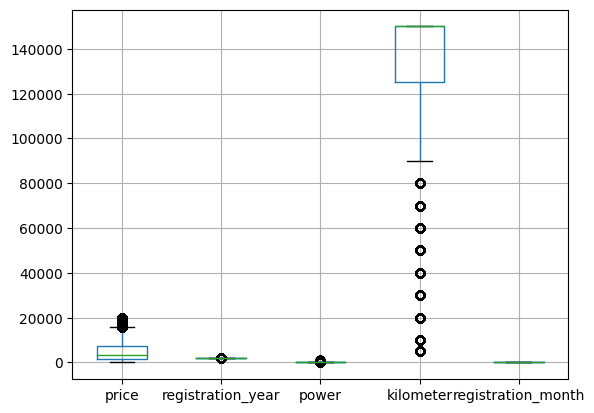

In [36]:
df.boxplot();

В столбцах присутствуют выбросы, поэтому используем устойчивый к выбросам `RobustScaler` ([сравнение масштабаторов на данных с выбросами](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)), чтобы признаки стали равными по значимости.

In [37]:
pd.options.mode.chained_assignment = None

scaler = RobustScaler()
scaler.fit(x_train[int_cols])
x_train[int_cols] = scaler.transform(x_train[int_cols])
x_valid[int_cols] = scaler.transform(x_valid[int_cols])
x_test[int_cols] = scaler.transform(x_test[int_cols])

### 3.8 Общий ущерб

In [38]:
print('Процент удалённых значений:', (old_df.shape[0] - df.shape[0]) * 100 / old_df.shape[0])

Процент удалённых значений: 27.850912466948294


<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты подготовки данных:</b>
        <ol>
        <li>Проведена работа со столбцами.</li>
        <li>Обработаны пропуски.</li>
        <li>Устранены аномалии.</li>
        <li>Данные разбиты на выборки.</li>
        <li>Признаки закодированы и масштабированы.</li>
        </ol><b>Процент удалённых значений: 27%.</b>
   </p>  
</div>

## 4 Работа с моделями
### 4.1 Обучение
Обучим разные модели без гиперпараметров и выберем лучшую.

In [39]:
def rmse(y, pred):
    return mean_squared_error(y, pred, squared=False)

In [50]:
def quality(mdl, return_qual=0, print_qual=1):
    scores = cross_val_score(mdl, x_train, y_train, cv=5, scoring=make_scorer(rmse, greater_is_better=False))
    quality = -scores.mean()
    print('Качество:', quality)
    
    if return_qual == 1:
        return quality

In [51]:
%%time
quality(LinearRegression())

Качество: 2966.2479450284973
CPU times: total: 2.31 s
Wall time: 1.59 s


In [52]:
%%time
quality(SGDRegressor(random_state=RANDOM_STATE))

Качество: 2967.9209403332547
CPU times: total: 6.98 s
Wall time: 7.12 s


In [53]:
%%time
quality(BayesianRidge())

Качество: 2966.2478552680286
CPU times: total: 3.19 s
Wall time: 1.62 s


In [54]:
%%time
quality(DecisionTreeRegressor(random_state=RANDOM_STATE))

Качество: 2240.5288016478626
CPU times: total: 8.47 s
Wall time: 8.51 s


In [56]:
%%time
quality(RandomForestRegressor(random_state=RANDOM_STATE))

Качество: 1700.3564287744466
CPU times: total: 9min 58s
Wall time: 10min 5s


In [57]:
%%time
quality(lgb.LGBMRegressor(random_state=RANDOM_STATE, metric='rmse', verbose=-1))

Качество: 1708.3343985516804
CPU times: total: 17.7 s
Wall time: 4.84 s


Можно выделить градиентный бустинг, подберём для него гиперпараметры.

### 4.2 Подбор гиперпараметров
Для подбора будем использовать байесовскую оптимизацию.

In [58]:
state = np.random.default_rng(RANDOM_STATE)

def hp_slctns(model, space):
    def func(args):
        mdl = model.set_params(**args)
        scores = cross_val_score(mdl, x_valid, y_valid, cv=5, scoring=make_scorer(rmse, greater_is_better=False), 
                                 error_score='raise')
        final_score = -sum(scores) / len(scores)
        return {'loss': final_score, 'status': STATUS_OK, 'model':mdl}
    
    trials = Trials()
    best = fmin(func,
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=10, 
                show_progressbar=True, 
                rstate=state)
    best_model = trials.best_trial['result']['model']
    
    print('Лучшие гиперпараметры:', best)
    return best_model

In [59]:
lgb_space = {
    'num_iterations': scope.int(hp.quniform('num_iterations', 100, 500, 2)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 100, 500, 2)), 
    'max_depth': scope.int(hp.quniform('max_depth', 100, 500, 2)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0), 
    'reg_alpha': hp.loguniform('reg_alpha', -16, 5), 
    'reg_lambda': hp.loguniform('reg_lambda', -16, 5)
}

best_lgb = hp_slctns(model=lgb.LGBMRegressor(random_state=RANDOM_STATE, metric='rmse', verbose=-1), 
                     space=lgb_space)

100%|████████████████████████████████████████████████| 10/10 [02:50<00:00, 17.09s/trial, best loss: 1709.0403817468662]
Лучшие гиперпараметры: {'learning_rate': 0.04712928409749913, 'max_depth': 468.0, 'num_iterations': 378.0, 'num_leaves': 424.0, 'reg_alpha': 0.05384002264136852, 'reg_lambda': 143.3628605961962}


### 4.3 Сравнение с константой моделью
Получим RMSE константной модели.

In [60]:
dummy_mean = quality(DummyRegressor(strategy='mean'), return_qual=1)
dummy_median = quality(DummyRegressor(strategy='median'), return_qual=1)

Качество: 4659.102405025495
Качество: 4942.9820789261885


Сохраним результаты лучшей константной модели в таблицу.

In [61]:
results_df = pd.DataFrame(columns=['Качество', 'Время обучения', 'Скорость предсказания'])
results_df.loc['Константная модель'] = [dummy_median, 0, 0]

Получим строку с  градиентным бустингом.

In [68]:
def save_time(model, best_model, name):
    mdl = model.set_params(**best_model.get_params())
    
    start_train_timer = time.time()
    mdl.fit(x_train, y_train)
    stop_train_timer = time.time() - start_train_timer
    
    start_pred_timer = time.time()
    pred = mdl.predict(x_test)
    score = rmse(y_test, pred)
    stop_pred_timer = time.time() - start_pred_timer
    
    results_df.loc[name] = [score, stop_train_timer, stop_pred_timer]
    
    return mdl

In [69]:
mdl = save_time(model=lgb.LGBMRegressor(), best_model=best_lgb, name='Градиентный бустинг')

Рассмотрим получившеюся таблицу.

In [70]:
results_df

,Качество,Время обучения,Скорость предсказания
Константная модель,4942.982079,0.00000,0.000000
Градиентный бустинг,1540.360004,4.34737,0.345078


### 4.4 Анализ важности признаков

In [73]:
def feature_importances():
    importances = mdl.feature_importances_
    sorted_idx = importances.argsort()
    
    plt.figure(figsize=(15, 10))
    plt.barh(range(x_train.shape[1]), importances[sorted_idx])
    plt.yticks(range(x_train.shape[1]), x_train.columns[sorted_idx])
    plt.xlabel('Важность признаков', fontsize=16)
    plt.title('График важности признаков' + '\n', fontsize=20)
    plt.grid(True)
    plt.show()

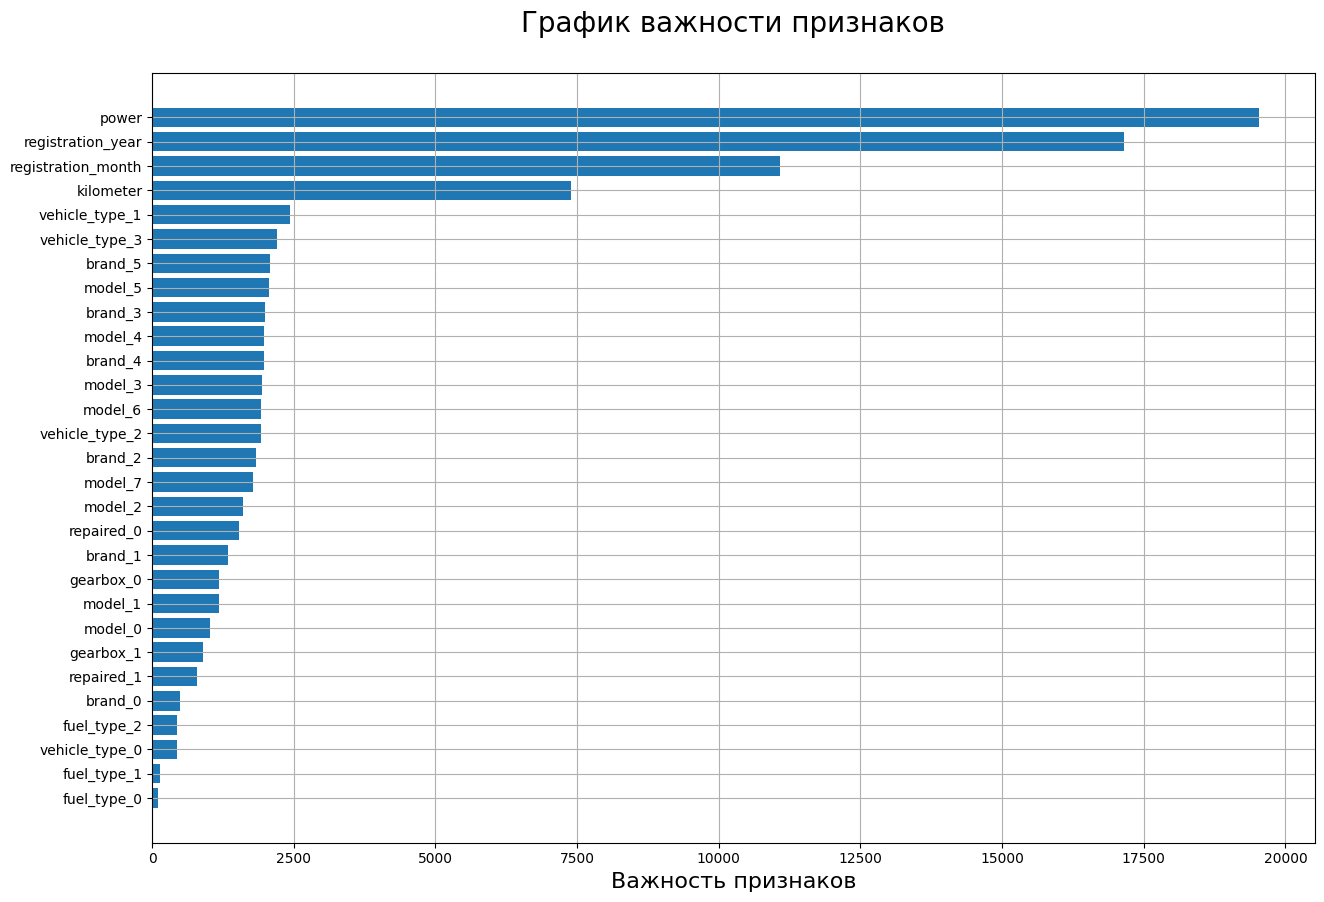

In [74]:
feature_importances()

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты работы с моделями:</b>
        <ol>
        <li>Разные модели обучены.</li>
        <li>Лучшая модель найдена, сравнена с константной и проверена на тестовой выборке, её MAE соответствует заявленным требованиям.</li>
        <li>Проведён анализ важности признаков.</li>
        </ol>
   </p>  
</div>

## 5 Отчёт

<hr style="color: steelblue; background-color: steelblue; height: 5px; border: none;">

### Описание ключевых шагов решения
- При педобработке данных была проведена работа со столбцами, обработаны пропуски, устранены аномалии, данные разбиты на выборки и признаки закодированы и масштабированы.
- Были обучены разные модели и выбрана лучшая.
- Лучшая модель была сравнена с константной и протестирована на тестовой выборке.

***

### Описание модели
Модель — `LGBMRegressor`.

Гиперпараметры:
- `random_state` = 0
- `learning_rate` = 0.04531853140527542
- `max_depth` = 380
- `n_estimators` = 368
- `num_leaves` = 476
- `reg_alpha` = 2.2897674399185596e-07
- `reg_lambda` = 3.2081956792213896e-06

***

### Итоговая метрика
RMSE 6.722796	

<hr style="color: steelblue; background-color: steelblue; height: 5px; border: none;">